### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

### Importing data and preprocessing

In [5]:
data = pd.read_csv('cancerdata.csv')

#creating a copy of the data
df = data.copy()

In [6]:
df.head()

,id,diagnosis,Sex,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
0,87139402,B,F,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,...,13.50,15.64,86.97,549.1,0.1385,0.1266,0.12420,0.09391,0.2827,0.06771
1,8910251,B,M,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,...,11.88,22.94,78.28,424.8,0.1213,0.2515,0.19160,0.07926,0.2940,0.07587
2,905520,B,M,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,...,12.41,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881
3,868871,B,F,11.28,13.39,73.00,384.8,0.11640,0.11360,0.04635,...,11.92,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784
4,9012568,B,F,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,...,16.20,15.73,104.50,819.1,0.1126,0.1737,0.13620,0.08178,0.2487,0.06766


Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)

b) texture (standard deviation of gray-scale values)

c) perimeter

d) area

e) smoothness (local variation in radius lengths)

f) compactness (perimeter^2 / area - 1.0)

g) concavity (severity of concave portions of the contour)

h) concave points (number of concave portions of the contour)

i) symmetry

j) fractal dimension ("coastline approximation" - 1)

In [29]:
#storing the above 9 features in a separate list
feature_list = ['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean',
               'points_mean','symmetry_mean','dimension_mean']

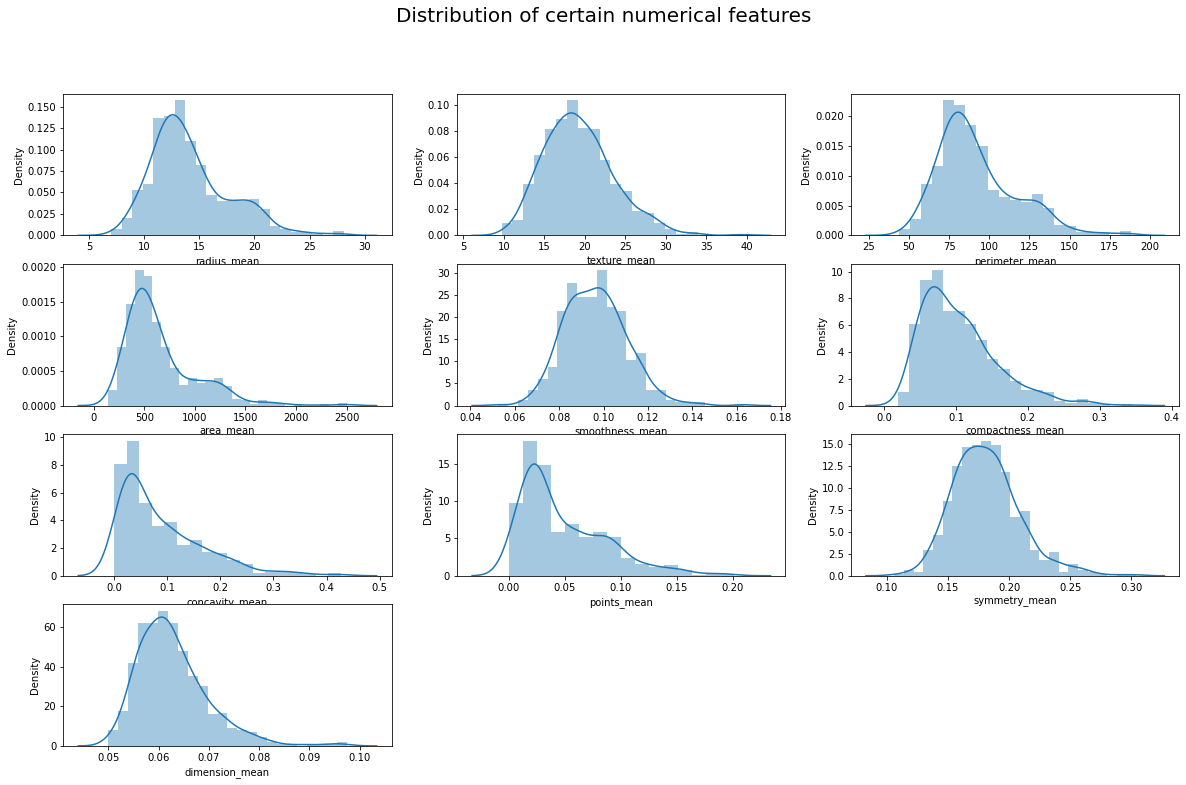

In [38]:
#plotting the distribution of these 10 columns
plt.rcParams['figure.figsize']=(20,12)
fig,ax = plt.subplots(nrows = 4, ncols = 3)
plt.suptitle('Distribution of certain numerical features',size = 20)
for col, axes in zip(feature_list, ax.flat[:len(feature_list)]):
    sns.distplot(x = df[col],ax = axes,axlabel = col)

for ax in [ax[3,1],ax[3,2]]:
    fig.delaxes(ax)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 569 non-null    int64  
 1   diagnosis          569 non-null    object 
 2   Sex                569 non-null    object 
 3   radius_mean        569 non-null    float64
 4   texture_mean       569 non-null    float64
 5   perimeter_mean     569 non-null    float64
 6   area_mean          569 non-null    float64
 7   smoothness_mean    569 non-null    float64
 8   compactness_mean   569 non-null    float64
 9   concavity_mean     567 non-null    float64
 10  points_mean        568 non-null    float64
 11  symmetry_mean      568 non-null    float64
 12  dimension_mean     569 non-null    float64
 13  radius_se          569 non-null    float64
 14  texture_se         569 non-null    float64
 15  perimeter_se       569 non-null    float64
 16  area_se            569 non

In [ ]:
df.describe().T

In [8]:
#dropping the id column as it is of no use
df.drop('id',axis = 1, inplace = True)

In [9]:
#separating input and output variables
X = df.drop('diagnosis',axis = 1)
y = df.diagnosis

In [10]:
#separating numerical and categorical features
num_features = X.select_dtypes(exclude = 'object').columns
cat_features = X.select_dtypes(include = 'object').columns

In [11]:
#checking for missing values
X.isnull().sum()

Sex                  0
radius_mean          0
texture_mean         0
perimeter_mean       0
area_mean            0
smoothness_mean      0
compactness_mean     0
concavity_mean       2
points_mean          1
symmetry_mean        1
dimension_mean       0
radius_se            0
texture_se           0
perimeter_se         0
area_se              0
smoothness_se        0
compactness_se       0
concavity_se         0
points_se            0
symmetry_se          0
dimension_se         0
radius_worst         0
texture_worst        0
perimeter_worst      0
area_worst           0
smoothness_worst     0
compactness_worst    0
concavity_worst      0
points_worst         0
symmetry_worst       0
dimension_worst      0
dtype: int64

3 columns have missing values all being numerical

In [12]:
# Imputation strategy for numeric columns
num_pipeline = Pipeline([('impute', SimpleImputer(strategy = 'mean'))])

cat_pipeline = Pipeline([('encoder', OneHotEncoder(drop = 'first'))]) #converting sex column into a binary variable

In [19]:
#Using ColumnTransformer to transform the columns of an array or Pandas DataFrame. 
#This estimator allows different columns or column subsets of the input to be transformed separately and 
#the features generated by each transformer will be concatenated to form a single feature space.
preprocess = ColumnTransformer([('categorical',cat_pipeline,cat_features),
                               ('numerical',num_pipeline,num_features)])

In [20]:
#fit the pipeline on our input features
processed = preprocess.fit(X)

In [21]:
#transforming the original data using the above pipeline
X_preprocessed = pd.DataFrame(processed.transform(X),columns = X.columns)
X_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex                569 non-null    float64
 1   radius_mean        569 non-null    float64
 2   texture_mean       569 non-null    float64
 3   perimeter_mean     569 non-null    float64
 4   area_mean          569 non-null    float64
 5   smoothness_mean    569 non-null    float64
 6   compactness_mean   569 non-null    float64
 7   concavity_mean     569 non-null    float64
 8   points_mean        569 non-null    float64
 9   symmetry_mean      569 non-null    float64
 10  dimension_mean     569 non-null    float64
 11  radius_se          569 non-null    float64
 12  texture_se         569 non-null    float64
 13  perimeter_se       569 non-null    float64
 14  area_se            569 non-null    float64
 15  smoothness_se      569 non-null    float64
 16  compactness_se     569 non

In [22]:
# Define scaling pipeline
scale_pipeline = Pipeline([('scale', MinMaxScaler())])

preprocess_2 = ColumnTransformer([('scaling',scale_pipeline,X_preprocessed.columns)])

#fitting the pipeline
processed_2 = preprocess_2.fit(X_preprocessed)

In [23]:
#transforming the data
X_clean = pd.DataFrame(processed_2.transform(X_preprocessed),columns = X_preprocessed.columns)
X_clean.head()

,Sex,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
0,0.0,0.252686,0.090632,0.242278,0.135992,0.452920,0.154684,0.093416,0.183897,0.454040,...,0.198150,0.096482,0.182081,0.089437,0.444628,0.096351,0.099201,0.322715,0.248768,0.083104
1,1.0,0.171281,0.312479,0.176145,0.086066,0.399476,0.292375,0.149649,0.131312,0.435354,...,0.140519,0.291045,0.138802,0.058887,0.331044,0.217530,0.153035,0.272371,0.271043,0.136626
2,1.0,0.192106,0.240785,0.187478,0.097434,0.497156,0.179928,0.071368,0.123260,0.330303,...,0.159374,0.384328,0.147019,0.070340,0.434062,0.117307,0.085224,0.255361,0.282476,0.155910
3,0.0,0.203464,0.124450,0.201852,0.102354,0.575697,0.289001,0.108599,0.238370,0.359091,...,0.141942,0.099947,0.130086,0.061148,0.432741,0.150294,0.069241,0.295911,0.105855,0.083956
4,0.0,0.388518,0.118363,0.372193,0.241060,0.243748,0.153242,0.079499,0.132058,0.333838,...,0.294201,0.098881,0.269386,0.155795,0.273592,0.142048,0.108786,0.281031,0.181747,0.082776


In [25]:
X_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Sex,569.0,0.467487,0.499381,0.0,0.000000,0.000000,1.000000,1.0
radius_mean,569.0,0.338222,0.166787,0.0,0.223342,0.302381,0.416442,1.0
texture_mean,569.0,0.323965,0.145453,0.0,0.218465,0.308759,0.408860,1.0
perimeter_mean,569.0,0.332935,0.167915,0.0,0.216847,0.293345,0.416765,1.0
area_mean,569.0,0.216920,0.149274,0.0,0.117413,0.172895,0.271135,1.0
smoothness_mean,569.0,0.394785,0.126967,0.0,0.304595,0.390358,0.475490,1.0
compactness_mean,569.0,0.260601,0.161992,0.0,0.139685,0.224679,0.340531,1.0
concavity_mean,569.0,0.208320,0.186730,0.0,0.069260,0.144213,0.306232,1.0
points_mean,569.0,0.242772,0.192660,0.0,0.100944,0.166501,0.366004,1.0
symmetry_mean,569.0,0.379601,0.138456,0.0,0.282323,0.369697,0.453030,1.0


---

In [42]:
#splitting the data
X_train,X_test,y_train,y_test = train_test_split(X_clean,y,test_size = 0.2,random_state = 0)

In [43]:
#checking the shapes and making sure all is okay
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (455, 31)
y_train shape:  (455,)
X_test shape:  (114, 31)
y_test shape:  (114,)


### Using KNN classifier

In [44]:
#instantiate the model
knn = KNeighborsClassifier(n_neighbors = 5)

#fitting the data
knn.fit(X_train,y_train)

#predictin on training data
train_pred = knn.predict(X_train)

In [46]:
# Cross table
pd.crosstab(y_train, train_pred, rownames = ['Actual'], colnames = ['Predictions']) 

Predictions,B,M
Actual,,
B,277,3
M,13,162


In [47]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score,confusion_matrix
accuracy_score(y_train, train_pred) # Accuracy measure

0.9648351648351648

In [49]:
# Predict the class on test data
pred_test = knn.predict(X_test)
pred_test

# Evaluate the model with test data
print('Accuracy score:',accuracy_score(y_test, pred_test))
pd.crosstab(y_test, pred_test, rownames = ['Actual'], colnames = ['Predictions']) 


Accuracy score: 0.9385964912280702


Predictions,B,M
Actual,,
B,75,2
M,5,32


In [50]:
# creating empty list variable 
acc = []

# running KNN algorithm from 3 to 50 nearest neighbours (odd numbers) and storing the accuracy values

for i in range(3, 50, 2):
    neigh = KNeighborsClassifier(n_neighbors = i)
    neigh.fit(X_train, y_train)
    train_acc = np.mean(neigh.predict(X_train) == y_train)
    test_acc = np.mean(neigh.predict(X_test) == y_test)
    diff = train_acc - test_acc
    acc.append([diff, train_acc, test_acc])

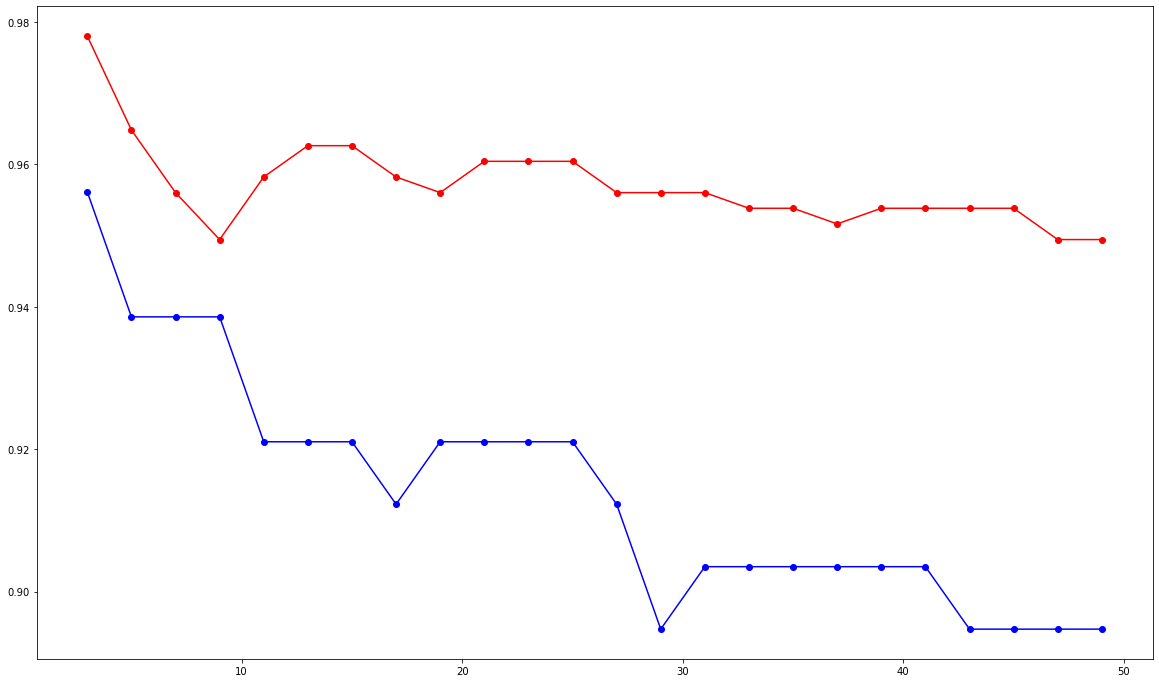

In [52]:
#plotting the accuracies
plt.plot(np.arange(3, 50, 2), [i[1] for i in acc], "ro-") #training accuracy
plt.plot(np.arange(3, 50, 2), [i[2] for i in acc], "bo-") #testing accuracy
plt.show()

We can clearly see that the model performs well on both training and testing data with 9 neighbors

In [53]:
#building a model with 9 neighbors
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

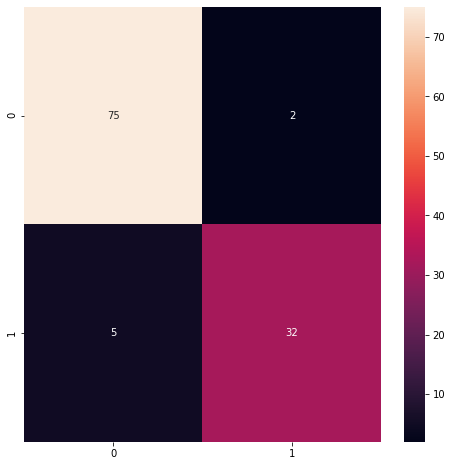

In [55]:
cm = confusion_matrix(y_test,y_pred)
#creating a heatmap
plt.figure(figsize = (8,8))
sns.heatmap(cm,annot = True)
plt.show()

### Using Logistic Regression Classifier

In [56]:
log = LogisticRegression()
log.fit(X_train,y_train)

LogisticRegression()

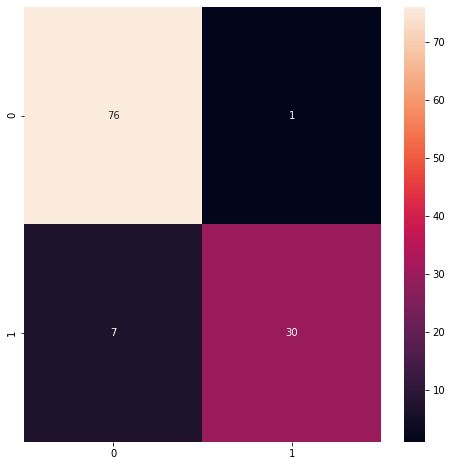

In [57]:
#predicting on testing data
y_pred = log.predict(X_test)

#plotting a confusion matrix
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (8,8))
sns.heatmap(cm,annot = True)
plt.show()

In [58]:
#checking the accuracy
accuracy_score(y_test,y_pred)

0.9298245614035088

As we can see both from accuracy and from the confusion matrix, logistic regression model performs slightly worse than KNN model

### Using decision tree classifier

In [59]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [60]:
#checking training accuracy
pred_train = dt.predict(X_train)

train_accuracy = accuracy_score(y_train,pred_train)

print(train_accuracy)

1.0


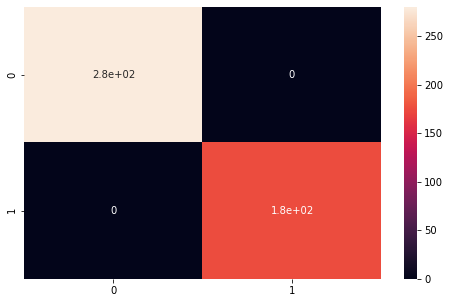

In [62]:
#plotting a confusion matrix
cm = confusion_matrix(y_train,pred_train)
plt.figure(figsize = (8,5))
sns.heatmap(cm,annot = True)
plt.show()

In [63]:
#checking test accuracy
pred_test = dt.predict(X_test)

test_accuracy = accuracy_score(y_test,pred_test)

print(test_accuracy)

0.9649122807017544


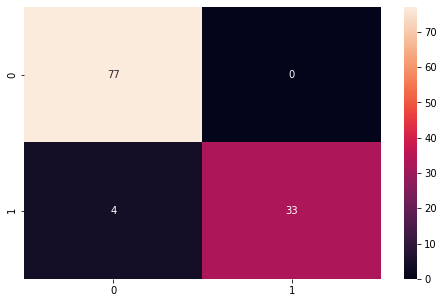

In [64]:
#plotting a confusion matrix
cm = confusion_matrix(y_test,pred_test)
plt.figure(figsize = (8,5))
sns.heatmap(cm,annot = True)
plt.show()

Decision Tree classifier has outperformed both KNN and Logistic Regression models so far

### Using Random Forests classifier

In [71]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [72]:
#checking training accuracy
pred_train = rf.predict(X_train)

train_accuracy = accuracy_score(y_train,pred_train)

print(train_accuracy)

1.0


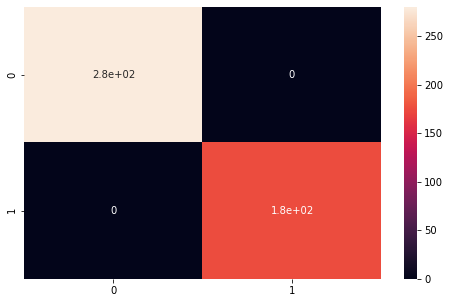

In [73]:
#plotting a confusion matrix
cm = confusion_matrix(y_train,pred_train)
plt.figure(figsize = (8,5))
sns.heatmap(cm,annot = True)
plt.show()

In [76]:
#checking test accuracy
pred_test = rf.predict(X_test)

test_accuracy = accuracy_score(y_test,pred_test)

print(test_accuracy)

0.956140350877193


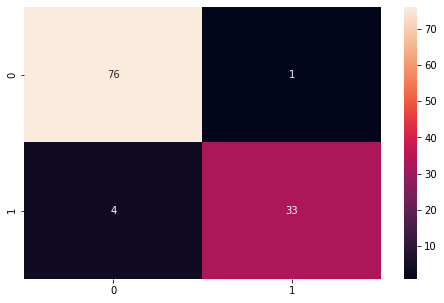

In [77]:
#plotting a confusion matrix
cm = confusion_matrix(y_test,pred_test)
plt.figure(figsize = (8,5))
sns.heatmap(cm,annot = True)
plt.show()